In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.spatial import distance as scipy_distance
from flax import linen as nn
import jax
from flax.training.train_state import TrainState
import optax
import pickle


In [2]:

def find_circles_adaptive(current_frame_gray, num_of_rafts, radii_hough,
                          adaptive_thres_blocksize=9, adaptive_thres_const=-20,
                          min_sep_dist=20, raft_center_threshold=60,
                          top_left_x=390, top_left_y=450, width_x=850, height_y=850):
    """
    find the centers of each raft
    :param current_frame_gray:
    :param num_of_rafts:
    :param radii_hough:
    :param adaptive_thres_blocksize:
    :param adaptive_thres_const:
    :param min_sep_dist:
    :param raft_center_threshold:
    :param top_left_x:
    :param top_left_y:
    :param width_x:
    :param height_y:
    :return: raft_centers, raft_radii, raft_count

    """
    # key data set initialization
    raft_centers = np.zeros((num_of_rafts, 2), dtype=int)
    raft_radii = np.zeros(num_of_rafts, dtype=int)
    
    # crop the image
    image_cropped = current_frame_gray[top_left_y: top_left_y + height_y, top_left_x: top_left_x + width_x]

    # threshold the image
    image_thres = cv.adaptiveThreshold(image_cropped, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,
                                       adaptive_thres_blocksize, adaptive_thres_const)
    # plt.figure()
    # plt.imshow(image_thres, cmap='gray')
    # plt.show()
    # use Hough transform to find circles
    hough_results = hough_circle(image_thres, np.arange(*radii_hough))
    accums, cx, cy, radii = hough_circle_peaks(hough_results, np.arange(*radii_hough))
    # assuming that the first raft (highest accumulator score) is a good one
    #    raft_centers[0,0] = cx[0]
    #    raft_centers[0,1] = cy[0]
    #    raft_radii[0] = radii[0]
    raft_count = 0  # starting from 1!

    # remove circles that belong to the same raft and circles that happened to be in between rafts
    for accumScore, detected_cx, detected_cy, detected_radius in zip(accums, cx, cy, radii):
        new_raft = 1
        if image_cropped[detected_cy, detected_cx] < raft_center_threshold:
            new_raft = 0
        elif image_cropped[detected_cy - detected_radius // 2: detected_cy + detected_radius // 2,
                           detected_cx - detected_radius // 2:detected_cx + detected_radius // 2].mean() \
                < raft_center_threshold:
            new_raft = 0
        #        elif  (detected_cx - width_x/2)**2 +  (detected_cy - height_y/2)**2 > lookup_radius**2:
        #            new_raft = 0
        else:
            cost_matrix = scipy_distance.cdist(np.array([detected_cx, detected_cy], ndmin=2),
                                               raft_centers[:raft_count, :], 'euclidean')
            if np.any(cost_matrix < min_sep_dist):  # raft still exist
                new_raft = 0
        if new_raft == 1:
            raft_centers[raft_count, 0] = detected_cx
            # note that raft_count starts with 1, also note that cx corresonds to columns number
            raft_centers[raft_count, 1] = detected_cy
            # cy is row number
            raft_radii[raft_count] = detected_radius
            raft_count = raft_count + 1
        if raft_count == num_of_rafts:
            #            error_message = 'all rafts found'
            break

    # convert the xy coordinates of the cropped image into the coordinates of the original image
    raft_centers[:, 0] = raft_centers[:, 0] + top_left_x
    raft_centers[:, 1] = raft_centers[:, 1] + top_left_y

    return raft_centers, raft_radii, raft_count

(506, 506, 3)
30
[3 3 3 3 3 3 7 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5 3 3 3 3 4 3 3]


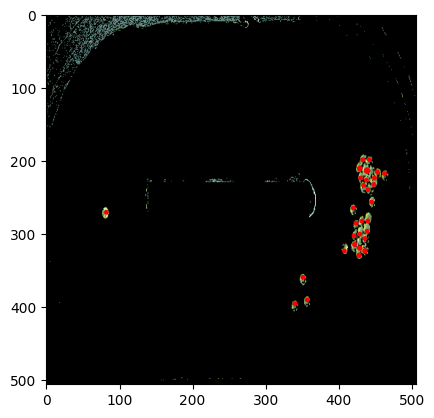

In [17]:
for i in range(1000,1001):
    image = cv.imread(f'../images/camera_image_{i:04d}.png')

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image =cv.resize(image, (506,506))
    mask = (image[:, :, 2] > image[:, :, 1]) & (image[:, :, 2] > image[:, :, 0])
    image[mask] = 0
    image[230:310, 140:360,:] = 0
    non_green_mask= (image[:, :, 1] < 120)
    image[non_green_mask] = 0

    print(image.shape)
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # for blocksize in range(3, 16, 2):  # Varying adaptive threshold blocksize
    #     for const in np.arange(-15, 0, 0.3):  # Varying adaptive threshold constant
    #         centers, radii, count = find_circles_adaptive(
    #             gray_image, 30, [3, 15], top_left_x=0, top_left_y=100, width_x=500, height_y=300,
    #             adaptive_thres_blocksize=blocksize, adaptive_thres_const=const,
    #             raft_center_threshold=80, min_sep_dist=8
    #         )
    #         if count == 30:  # Display only when 30 particles are detected
    #             print(f"Blocksize: {blocksize}, Const: {const}")
    #             print(f"Count: {count}")
    #             print(f"Radii: {radii}")
    #             plt.figure()
    #             plt.imshow(image)
    #             plt.scatter(centers[:, 0], centers[:, 1], c='r', s=radii * 2)
    #             plt.title(f"Blocksize: {blocksize}, Const: {const}")
    #             plt.show()
    centers, radii, count = find_circles_adaptive(gray_image, 30, [3, 15], top_left_x=0, top_left_y=100, width_x=500, height_y=300, adaptive_thres_blocksize=3, adaptive_thres_const=-0.4, raft_center_threshold=60, min_sep_dist=8)
    print(count)
    print(radii)
    plt.figure()
    plt.imshow(image)
    plt.scatter(centers[:, 0], centers[:, 1], c='r', s=radii*2)
    # plt.show()
    